## Training the Neural Additive Model (NAM)

To train the model, run the following command:

```bash
python -m neural_additive_models.nam_train \
  --dataset_name=Housing \
  --training_epochs=1000 \
  --regression=True \
  --logdir=. \
  --batch_size=1024 \
  --learning_rate=0.00674 \
  --dropout=0 \
  --fold_num=1 \
  --output_regularization=0.001 \
  --l2_regularization=1e-6 \
  --debug=True \
  --activation=relu


In [ ]:
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Directory containing checkpoint files
ckpt_dir = "fold_1/split_1/model_0/best_checkpoint"

# Automatically find the latest checkpoint in the folder
checkpoint = tf.train.latest_checkpoint(ckpt_dir)

# Fallback if no checkpoint metadata file is found
if checkpoint is None:
    # Try to find the newest model.ckpt-* manually
    ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith('.index')]
    assert ckpt_files, f"No checkpoint files found in {ckpt_dir}"
    latest_step = max(int(f.split('-')[1].split('.')[0]) for f in ckpt_files)
    checkpoint = os.path.join(ckpt_dir, f"model.ckpt-{latest_step}")

tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(checkpoint + ".meta")
    saver.restore(sess, checkpoint)
    print("✅ Model restored successfully from:", checkpoint)


INFO:tensorflow:Restoring parameters from fold_1/split_1/model_0/best_checkpoint\model.ckpt-1400
✅ Model restored successfully from: fold_1/split_1/model_0/best_checkpoint\model.ckpt-1400


In [ ]:
import neural_additive_models.data_utils as data_utils
import neural_additive_models.graph_builder as graph_builder
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp

In [4]:
def load_col_min_max(dataset_name):
  """Loads the dataset according to the `dataset_name` passed."""
  if dataset_name == 'Housing':
    dataset = data_utils.load_california_housing_data()
  elif dataset_name == 'BreastCancer':
    dataset = data_utils.load_breast_data()
  elif dataset_name == 'Recidivism':
    dataset = data_utils.load_recidivism_data()
  elif dataset_name == 'Fico':
    dataset = data_utils.load_fico_score_data()
  elif dataset_name == 'Mimic2':
    dataset = load_mimic2_data()
  elif dataset_name == 'Credit':
    dataset = data_utils.load_credit_data()
  else:
    raise ValueError('{} not found!'.format(dataset_name))

  if 'full' in dataset:
    dataset = dataset['full']
  x = dataset['X']
  col_min_max = {}
  for col in x:
    unique_vals = x[col].unique()
    col_min_max[col] = (np.min(unique_vals), np.max(unique_vals))
  return col_min_max

def inverse_min_max_scaler(x, min_val, max_val):
  return (x + 1)/2 * (max_val - min_val) + min_val 

In [5]:
dataset_name = 'Housing' #@param {'type': 'string'}
is_regression = dataset_name in ['Housing', 'Fico']
housing_data =  data_utils.load_dataset(dataset_name)
data_x, data_y, column_names = housing_data
col_min_max = load_col_min_max(dataset_name)

In [ ]:
ckpt_dir = r".\fold_1\split_1\model_0\best_checkpoint"
ckpt_path = tf.train.latest_checkpoint(ckpt_dir)
if ckpt_path is None:   # fallback if no 'checkpoint' metadata file
    ckpt_path = osp.join(ckpt_dir, "model.ckpt-1400")
print("Using checkpoint:", ckpt_path)

Using checkpoint: .\fold_1\split_1\model_0\best_checkpoint\model.ckpt-1400


In [7]:
import re 
reader = tf.train.NewCheckpointReader(ckpt_path)
var_map = reader.get_variable_to_shape_map()

units_by_idx = {}
for name, shape in var_map.items():
    m = re.match(r"^model_0/activation_layer_(\d+)/beta$", name)
    if m:
        units_by_idx[int(m.group(1))] = shape[1]

num_units_list = [units_by_idx[i] for i in sorted(units_by_idx)]
num_inputs = len(num_units_list)
print("Feature widths:", num_units_list)
print("Num input features:", num_inputs)

Feature widths: [1000, 104, 1000, 1000, 1000, 1000, 1000, 1000]
Num input features: 8


In [8]:
from neural_additive_models.models import NAM
tf.reset_default_graph()
nam = NAM(
    num_inputs=num_inputs,
    num_units=num_units_list,
    dropout=0.0,
    feature_dropout=0.0,
    activation='relu',
    shallow=False,
    trainable=False,
    name_scope='model_0'
)
_ = nam(np.zeros((1, num_inputs), np.float32), training=False)

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)
print("✅ Restored NAM from checkpoint.")

INFO:tensorflow:Restoring parameters from .\fold_1\split_1\model_0\best_checkpoint\model.ckpt-1400
✅ Restored NAM from checkpoint.


In [9]:
def partition(lst, batch_size):
    lst_len = len(lst)
    index = 0
    while index < lst_len:
        yield lst[index: batch_size + index]
        index += batch_size

def generate_predictions(gen, nn_model, sess):
    """Run predictions batch-by-batch inside a TF1 session."""
    y_pred = []
    while True:
        try:
            x = next(gen)
            pred = sess.run(nn_model(x, training=False))
            y_pred.extend(pred)
        except StopIteration:
            break
    return np.array(y_pred)

def get_test_predictions(nn_model, x_test, sess, batch_size=256):
    batch_size = min(batch_size, x_test.shape[0])
    generator = partition(x_test, batch_size)
    return generate_predictions(generator, nn_model, sess)

def get_feature_predictions(nn_model, dataset_name, sess):
    feature_predictions = []
    unique_features = compute_features(dataset_name)
    for c, i in enumerate(unique_features):
        f_preds = sess.run(nn_model.feature_nns[c](i, training=nn_model._false))
        feature_predictions.append(f_preds)
    return feature_predictions

def compute_features(dataset_name):
  x_data, _, _ = data_utils.load_dataset(dataset_name)
  single_features = np.split(x_data, x_data.shape[1], axis=1)
  unique_features = [np.unique(f, axis=0) for f in single_features]
  return unique_features


In [10]:
# --- Test set predictions ---
test_predictions = get_test_predictions(nam, data_x.astype(np.float32), sess)
print("Predictions length:", len(test_predictions))

# --- Feature-wise predictions (shape functions) ---
unique_features = compute_features(dataset_name)
feature_predictions = get_feature_predictions(nam, dataset_name, sess)

# --- Evaluate RMSE or AUROC ---

is_regression = True
test_metric = graph_builder.calculate_metric(
    data_y, test_predictions, regression=is_regression)
metric_str = 'RMSE' if is_regression else 'AUROC'
print(f'{metric_str}: {test_metric:.4f}')


Predictions length: 20640
RMSE: 0.5697


In [ ]:
NUM_FEATURES = data_x.shape[1]
SINGLE_FEATURES = np.split(data_x, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}
for i, col in enumerate(column_names):
  min_val, max_val = col_min_max[col]
  UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      UNIQUE_FEATURES[i][:, 0], min_val, max_val)
  SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(
      SINGLE_FEATURES[i][:, 0], min_val, max_val)

In [ ]:
FEATURE_LABEL_MAPPING = {}
FEATURE_LABEL_MAPPING['Recidivism'] = {
    'race': (['African\nAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Native\nAmerican', 'Other'], 90),
    'sex': (['Female', 'Male'], None)
}

FEATURE_LABEL_MAPPING['Mimic2'] = {
    'AIDS': (['No', 'Yes'], None),
    'Lymphoma': (['No', 'Yes'], None),
    'MetastaticCancer': (['No', 'Yes'], None),
}
FEATURE_LABEL_MAPPING['Fico'] = {}
FEATURE_LABEL_MAPPING['Housing'] = {}


COL_NAMES = {}
COL_NAMES['Recidivism'] = {
    'age' : 'Age',
    'race': 'Race',
    'sex': 'Gender',
    'priors_count': 'Prior Counts',
    'length_of_stay': 'Length of Stay',
    'c_charge_degree': 'Charge Degree'
  }

COL_NAMES['Housing'] = {
    'MedInc': 'Median Income',
    'HouseAge': 'Median House Age',
    'AveRooms': '# Avg Rooms',
    'AveBedrms': '# Avg Bedrooms',
    'Population': 'Block Population',
    'AveOccup': '# Avg Occupancy',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude'
  }

COL_NAMES['Fico'] = {
    'MSinceOldestTradeOpen': 'Months Since Oldest Trade Open',
    'MSinceMostRecentTradeOpen':	'Months Since Most Recent Trade',
    'AverageMInFile':	'Average Months in File',
    'NumSatisfactoryTrades': '# Satisfactory Trades',	
    'NumTrades60Ever2DerogPubRec': '# Trades 60+ Ever',	
    'NumTrades90Ever2DerogPubRec':	'# Trades 90+ Ever',	
    'NumTotalTrades': '# Total Trades',
    'NumTradesOpeninLast12M': '# Trades Open in Last 12 Months',
    'PercentTradesNeverDelq':	'% Trades Never Delinquent',
    'MSinceMostRecentDelq':	'Months Since Most Recent Delinquency',	
    'MaxDelq2PublicRecLast12M':	'Max Delq/Public Records Last Year',
    'MaxDelqEver':	'Max Delinquency Ever',
    'PercentInstallTrades':	'% Installment Trades',	
    'NetFractionInstallBurden':	'Net Fraction Installment Burden',
    'NumInstallTradesWBalance': 'Number Installment Trades with Balance',	
    'MSinceMostRecentInqexcl7days':	'Months Since Most Recent Inquiry\n excluding 7 days',	
    'NumInqLast6M': '# Inquiries in Last 6 Months',
    'NumInqLast6Mexcl7days': '# Inquiries in Last 6 Months \n excluding 7 days',
    'NetFractionRevolvingBurden':	'Net Fraction Revolving Burden',
    'NumRevolvingTradesWBalance':	'# Revolving Trades with Balance',	
    'NumBank2NatlTradesWHighUtilization':	'# Bank/Natl Trades with high utilization ratio',	
    'PercentTradesWBalance': '% Trades with Balance',
    'delinquent': 'Delinquent',
    'inquiry': 'Inquiry',
}


if dataset_name in ['Credit', 'Mimic2']:
  COL_NAMES[dataset_name] = {x: x for x in column_names}


In [ ]:

if dataset_name in ['Housing', 'Credit']:
  CATEGORICAL_NAMES = []
elif dataset_name == 'Mimic2':
  CATEGORICAL_NAMES = ['AIDS','AdmissionType','GCS','Lymphoma',
                       'Temperature','MetastaticCancer','Renal']
elif dataset_name == 'Recidivism':
  CATEGORICAL_NAMES = ['race','sex','c_charge_degree']
elif dataset_name == 'Fico':
  CATEGORICAL_NAMES = ['delinquent', 'inquiry', 'MaxDelqEver', 'MaxDelq2PublicRecLast12M']
else:
  raise ValueError('{} not found!'.format(dataset_name))


# categorical_names = ['AIDS','AdmissionType','GCS','Lymphoma','Temperature','MetastaticCancer','Renal']
avg_hist_data = {col: predictions for col, predictions in zip(column_names, feature_predictions)}

In [ ]:
ALL_INDICES = {}
MEAN_PRED = {}

for i, col in enumerate(column_names):
  x_i = data_x[:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')
for col in column_names:
  MEAN_PRED[col] =  np.mean([avg_hist_data[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'MedInc': 0.3129017, 'HouseAge': 0.1680216, 'AveRooms': 0.0987604, 'AveBedrms': 0.012055452, 'Population': 0.02700882, 'AveOccup': 0.28964806, 'Latitude': 0.68722135, 'Longitude': 0.4682915}


In [ ]:
def compute_mean_feature_importance(avg_hist_data):
  mean_abs_score = {}
  for k in avg_hist_data:
    mean_abs_score[k] = np.mean(np.abs(avg_hist_data[k] - MEAN_PRED[k]))
  x1, x2 = zip(*mean_abs_score.items())
  return x1, x2

def plot_mean_feature_importance(x1, x2, width = 0.3):
  fig = plt.figure(figsize=(5, 4))
  ind = np.arange(len(x1))  # the x locations for the groups
  x1_indices = np.argsort(x2)
  cols_here = [cols[i] for i in x1_indices]
  # x1_here = [x12[i] for i in x1_indices]
  x2_here = [x2[i] for i in x1_indices]

  plt.bar(ind, x2_here, width, label='NAMs')
  # plt.bar(ind+width, x1_here, width, label='EBMs')
  plt.xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
  plt.ylabel('Mean Absolute Score', fontsize='x-large')
  plt.legend(loc='upper right', fontsize='large')
  plt.title(f'Overall Importance: {dataset_name}', fontsize='x-large')
  plt.show()
  return fig

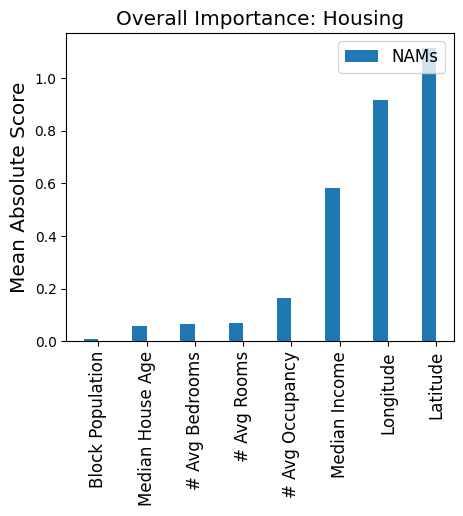

In [ ]:

x1, x2 = compute_mean_feature_importance(avg_hist_data)
cols = [COL_NAMES[dataset_name][x] for x in x1]
fig = plot_mean_feature_importance(x1, x2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols, 
                            n_blocks=5, color=[0.9, 0.5, 0.5], 
                            feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
  max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 

  for i, (name, pred) in enumerate(hist_data_pairs):

    # unique_x_data, single_feature_data, pred = data
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
    ax = plt.subplot(num_rows, num_cols, i+1)
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    x_n_blocks = min(n_blocks, len(unique_x_data))
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    segments = (max_x - min_x) / x_n_blocks
    density = np.histogram(single_feature_data, bins=x_n_blocks)
    normed_density = density[0] / np.max(density[0])
    rect_params = []
    for p in range(x_n_blocks):
      start_x = min_x + segments * p
      end_x = min_x + segments * (p + 1)
      # start_insert_index = min(
      #     max(0, np.searchsorted(density[1], start_x) - 1), x_n_blocks - 1)
      # end_insert_index = min(
      #     max(0, np.searchsorted(density[1], end_x) - 1), x_n_blocks - 1)
      # d = (normed_density[start_insert_index] + normed_density[end_insert_index])/2
      d = min(1.0, 0.01 + normed_density[p])
      rect_params.append((d, start_x, end_x))

    for param in rect_params:
      alpha, start_x, end_x = param 
      rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x, 
                               max_y - min_y + 1, linewidth=0.01, 
                              edgecolor=color, facecolor=color, alpha=alpha)
      ax.add_patch(rect)


def plot_all_hist(hist_data, num_rows, num_cols,  color_base, 
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0, 
                  feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  if min_y is None:
    min_y = np.min([np.min(a) for _, a in hist_data_pairs])
  if max_y is None:
    max_y = np.max([np.max(a) for _, a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif
  col_mapping = COL_NAMES[dataset_name]
  feature_mapping = FEATURE_LABEL_MAPPING[dataset_name] 

  total_mean_bias = 0

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use] 
  
  for i, (name, pred) in enumerate(hist_data_pairs):
    mean_pred = MEAN_PRED[name] #np.mean(pred)
    total_mean_bias += mean_pred
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    plt.subplot(num_rows, num_cols, i+1)

    if name in CATEGORICAL_NAMES:
      unique_x_data = np.round(unique_x_data, decimals=1)
      if len(unique_x_data) <= 2:
        step_loc = "mid"
      else:
        step_loc = "post"
      unique_plot_data = np.array(unique_x_data) - 0.5
      unique_plot_data[-1] += 1
      plt.step(unique_plot_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, where=step_loc, alpha=alpha)

      if name in feature_mapping:
        labels, rot = feature_mapping[name]
      else:
        labels = unique_x_data
        rot = None
      plt.xticks(unique_x_data, labels=labels, fontsize='x-large', rotation=rot)
    else:
      plt.plot(unique_x_data, pred - mean_pred, color=color_base, 
               linewidth=linewidth, alpha=alpha)
      plt.xticks(fontsize='x-large')
  
   
    plt.ylim(min_y, max_y)
    plt.yticks(fontsize='x-large')
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    if name in CATEGORICAL_NAMES:
      min_x -= 0.5
      max_x += 0.5
    plt.xlim(min_x, max_x)
    if i % num_cols == 0:
      plt.ylabel('House Price Contribution', fontsize='x-large')
    plt.xlabel(col_mapping[name], fontsize='x-large')
  return min_y, max_y

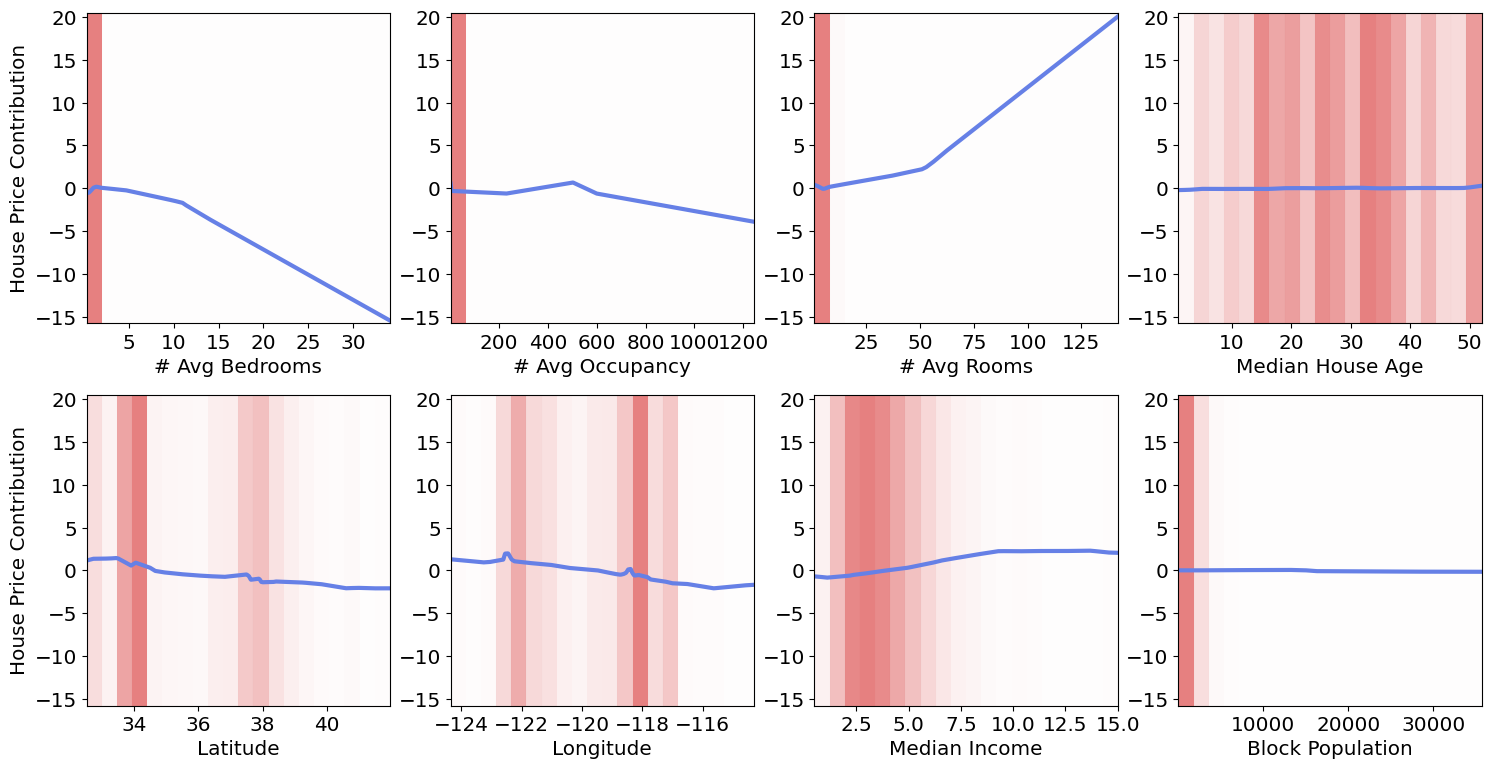

In [18]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS =  4#@param {'type': 'integer'}
N_BLOCKS =  20#@param 

MIN_Y = None
MAX_Y = None


NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 4.5, NUM_ROWS * 4.5),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data, NUM_ROWS, NUM_COLS, COLORS[2],
                             min_y=MIN_Y, max_y=MAX_Y, feature_to_use=column_names)
shade_by_density_blocks(avg_hist_data, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=column_names)

# This is for plotting individual plots when there are multiple models
"""
for pred in feature_predictions:
  model_hist = {col: pred[0, i] for i, col in enumerate(column_names)}
  plot_all_hist(model_hist, NUM_ROWS, NUM_COLS,
                color_base=[0.3, 0.4, 0.9, 0.2], alpha=0.06,
                linewidth=0.1, min_y=MIN_Y, max_y=MAX_Y, feature_to_use=features)
"""
plt.subplots_adjust(hspace=0.23)
plt.show()